In [1]:
from multicontact_api import ContactSequenceHumanoid
from database import *
from memmo_utils import *

import numpy as np
import rospy
from IPython.display import clear_output

from regression import *
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4,suppress=True)

import matplotlib.pyplot as plt

from visualization_msgs.msg import MarkerArray
from std_msgs.msg._ColorRGBA import ColorRGBA
import os

from memmo_utils import *
from sklearn.mixture import GaussianMixture
import pickle
import transforms3d

#### Initialise visualisation 

In [2]:
viz = Visual()
#rospy.init_node('foot_markers')
foot_marker = RvizMarker(name='marker_array')

object_marker = RvizMarker(name='objects_marker', marker_type = Marker.CUBE, n = 5, max_n = 5, scale = Vector3(1.2,1.2,1.2))

#### Add Objects to the scene 

In [3]:
object_marker.markers[0].type = Marker.CYLINDER
object_marker.markers[0].color = ColorRGBA(0,1,0,1)
object_marker.markers[0].scale = Vector3(2*.7,2*.7,2*.8)

object_marker.markers[1].color = ColorRGBA(1,0,0,1)
object_marker.markers[1].scale = Vector3(1.2,1.2,.8)


object_marker.markers[2].type = Marker.SPHERE
object_marker.markers[2].color = ColorRGBA(0,0,1,1)
object_marker.markers[2].scale = Vector3(2*.8,2*.8,2*.8)

object_marker.markers[3].type = Marker.SPHERE
object_marker.markers[3].color = ColorRGBA(1,1,1,1)
object_marker.markers[3].scale = Vector3(2*.9,2*.9,2*.9)

object_marker.markers[4].type = Marker.CYLINDER
object_marker.markers[4].color = ColorRGBA(0,0,0,1)
object_marker.markers[4].scale = Vector3(2*.7,2*.7,2*.8)

poses = []
poses += [np.array([0.5,-1,0,0.])]
poses += [np.array([0.9,2.,0,0.])]
poses += [np.array([-2.2,.3,0.4,0.])]
poses += [np.array([4.,0.,0.4,0.])]
poses += [np.array([-5,2,0.5,0.])]

object_marker.publish(poses)

In [4]:
def extract_contact_sequence(filename):
    cs = ContactSequenceHumanoid(0)
    cs.loadFromBinary(filename)
    raw_phases = cs.contact_phases

    T_lefts = []
    T_rights = []
    num_phases = len(raw_phases)
    for cur_phase in raw_phases:
        rf = cur_phase.RF_patch
        if rf.active:
            T_right = SE3toMat(rf.placement)
            T_rights += [T_right]
        else:
            T_rights += [None]
        lf = cur_phase.LF_patch
        if lf.active:
            T_left = SE3toMat(lf.placement)
            T_lefts += [T_left]
        else:
            T_lefts += [None]

    return T_lefts, T_rights

#### Load Contacts 

In [5]:
ROOT = '/home/rli/temp/talos_randomObstacle/'
filenames = os.listdir(ROOT)

In [6]:
foot_poses_list = []
len_contacts = []
num_error = 0
for i in range(len(filenames)):
    try:
        filename = ROOT + filenames[i] + '/res/contact_sequences/talos_randomObstacle.cs'
        T_l, T_r = extract_contact_sequence(filename)
        foot_poses = construct_foot_poses(T_l,T_r)
        foot_poses_list+= [foot_poses]
        len_contacts += [len(foot_poses)]
    except:
        num_error +=1 
        continue

In [7]:
len(foot_poses_list)

334

### Learning contact sequences 

#### Constructing the inputs

#### Constructing the outputs 

In [8]:
def angle_to_xy(foot_pose):
    foot_pose_mod = np.zeros((len(foot_pose),8))
    foot_pose_mod[:,0:2] = foot_pose[:,0:2]
    foot_pose_mod[:,4:6] = foot_pose[:,3:5]
    
    foot_pose_mod[:,2] = np.cos(foot_pose[:,2])
    foot_pose_mod[:,3] = np.sin(foot_pose[:,2])
    
    foot_pose_mod[:,6] = np.cos(foot_pose[:,5])
    foot_pose_mod[:,7] = np.sin(foot_pose[:,5])
    
    return foot_pose_mod

def angle_to_xy2(foot_pose):
    foot_pose_mod = np.zeros((len(foot_pose),4))
    foot_pose_mod[:,0:2] = foot_pose[:,0:2]
    
    foot_pose_mod[:,2] = np.cos(foot_pose[:,2])
    foot_pose_mod[:,3] = np.sin(foot_pose[:,2])
    
  
    return foot_pose_mod
    
def xy_to_angle(foot_pose_mod):
    foot_pose = np.zeros((len(foot_pose_mod),3))
    foot_pose[:,0:2] = foot_pose_mod[:,0:2]
    
    foot_pose[:,2] = np.arctan2(foot_pose_mod[:,3],foot_pose_mod[:,2])
    
    return foot_pose

In [9]:
guide_output = []
foot_pose_output = []
len_pose_output = []
num_steps = 200

x_inputs = []
    

for i in range(len(foot_poses_list)):
    foot_pose = foot_poses_list[i]

    init_pos = 0.5*(foot_pose[0,:2]+foot_pose[1,:2])
    goal_pos = 0.5*(foot_pose[-2,:2]+foot_pose[-1,:2])
    x_input = np.hstack([init_pos, goal_pos])

    foot_pose = foot_pose.reshape(-1,6)
    
    #skip every other footstep
    foot_pose = foot_pose[::2]
    
    if len(foot_pose) < 4:
        continue
    len_pose_output += [len(foot_pose)]
    
    #change the angle description to x and y
    foot_pose_mod = angle_to_xy(foot_pose) 
    foot_pose_mod = subsample(foot_pose_mod,num_steps)
    
    guide = 0.5*(foot_pose_mod[:,:4] + foot_pose_mod[:,4:])
    guide_output += [guide.flatten()]
    
    foot_pose_output += [foot_pose_mod.flatten()]
    x_inputs += [x_input]


guide_output = np.array(guide_output)
len_pose_output = np.array(len_pose_output)
foot_pose_output = np.array(foot_pose_output)
x_inputs = np.array(x_inputs)


#### Use RBF 

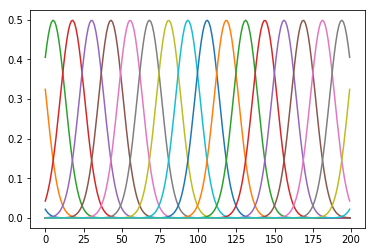

In [10]:
rbf_num_contact = 20
Phi_contact = define_RBF(dof=None, nbStates = rbf_num_contact, offset = 20, width = 8, T = num_steps, coeff = 10)
plt.plot(Phi_contact)
raw_input()
clear_output()

In [11]:
w_guides = []
for guide in guide_output:
    guide = guide.reshape(-1,4)
    w,_,_,_ = np.linalg.lstsq(Phi_contact,guide,rcond=1e-4)
    w_guides += [w.flatten()]
w_guides = np.array(w_guides)

#### Plot the RBF Results 

#### Train the regressors 

In [13]:
gpr_pose = GPy_Regressor(dim_input = 4)
gpr_len_pose = GPy_Regressor(dim_input = 4)
gpr_pose.fit(x_inputs,w_guides,num_restarts= 5)
gpr_len_pose.fit(x_inputs,len_pose_output[:,None],num_restarts = 5)
clear_output()


nn_pose = NN_Regressor()
nn_len_pose = NN_Regressor()
nn_pose.fit(x_inputs,w_guides[:,None])
nn_len_pose.fit(x_inputs,len_pose_output[:,None])

#### Approximate the input distributions 

In [14]:
gmm_input = GaussianMixture(n_components=10)
gmm_input.fit(x_inputs)
clear_output()

#### Test the Memory 

In [15]:
def generate_random_guide():
    #obtain an input
    x_input,_ = gmm_input.sample()
    #x_input = x_inputs[i:i+1]
    
    #predict the foot_pose
    w_guide,_ = gpr_pose.predict(x_input)
    w_guide = w_guide.reshape(-1,4)
    guide = np.dot(Phi_contact,w_guide)
    len_pose,_ = gpr_len_pose.predict(x_input)
    len_pose = int(len_pose[0,0])
    guide = subsample(guide,len_pose)
    
    #visualize the initial and goal location
    translation = (x_input[0,0],x_input[0,1],.1)
    rotation = (0,0,0,1)    
    viz.br.sendTransform(
        translation,rotation,rospy.Time.now(),"init","world")
    translation = (x_input[0,2],x_input[0,3],.1)
    rotation = (0,0,0,1)    
    viz.br.sendTransform(translation,rotation,rospy.Time.now(),"goal","world")

    #transform xy to angle
    guide = xy_to_angle(guide)
    guide = guide.reshape(-1,3)

    #add intermediate footstep
    #foot_pose = add_intermediate(foot_pose)

    #publish
    foot_marker.publish(guide)
    clear_output()
    return guide

### Learn the contact, given the guide 

In [16]:
def move_foot_to_zero(foot_poses):
    init_pose = 0.5*(foot_poses[0]+foot_poses[1])
    T_init = PosetoMat(init_pose)
    T_init_inv = np.linalg.inv(T_init)
    foot_poses_mod = []
    for f in foot_poses:
        cur_pose = PosetoMat(f)
        cur_pose = np.dot(T_init_inv,cur_pose)
        foot_poses_mod += [MattoPose(cur_pose)]
    return np.array(foot_poses_mod)

In [17]:
def transform_foot_poses(foot_poses, T):
    d = foot_poses[0].shape[0]
    foot_poses_mod = []
    for f in foot_poses:
        if d == 4:
            f = xy_to_angle(f[None,:])[0]
        cur_pose = PosetoMat(f)    
        cur_pose = np.dot(T,cur_pose)
        cur_pose = MattoPose(cur_pose)
        if d == 4:
            cur_pose = angle_to_xy2(cur_pose[None,:])[0]
        foot_poses_mod += [cur_pose]
    return np.array(foot_poses_mod)

In [18]:
def compute_init_T(foot_pose):
    init_pose = 0.5*(foot_pose[:4]+foot_pose[4:])
    init_pose = xy_to_angle(init_pose[None,:])[0]
    T_init = PosetoMat(init_pose)
    return T_init

In [19]:
x_input_guides = []
y_contacts = []
for i in range(len(guide_output)):
    guide = guide_output[i].reshape(-1,4)
    foot_pose = foot_pose_output[i].reshape(-1,8)

    #resample
    len_pose = len_pose_output[i]
    guide = subsample(guide,len_pose)
    foot_pose = subsample(foot_pose, len_pose)

    #split into one-step movement data
    for j in range(len(guide)-1):
        cur_guide = guide[j]
        next_guide = guide[j+1]
        cur_foot_pose = foot_pose[j]
        next_foot_pose = foot_pose[j+1]
        
        #transform everything to start from zero
        T_init = compute_init_T(cur_foot_pose)
        T_init_inv = np.linalg.inv(T_init)
        res = transform_foot_poses([cur_foot_pose[:4],cur_foot_pose[4:],\
                                    next_foot_pose[:4],next_foot_pose[4:],\
                                   next_guide], T_init_inv)
        cur_foot_pose = np.concatenate([res[0],res[1]])
        next_foot_pose = np.concatenate([res[2],res[3]])
        next_guide = res[4]
        
        x_input = np.concatenate([cur_foot_pose, next_guide])
        y = next_foot_pose
        x_input_guides += [x_input]
        y_contacts += [y]
        
x_input_guides = np.array(x_input_guides)
y_contacts = np.array(y_contacts)

#### Visualise the training data 

In [20]:
def predict_multistep_contact(guide, func=None):
    #get initial contact
    vec = np.array([guide[0,3],-guide[0,2]])
    vec = normalize(vec)
    cur_left = guide[0].copy()
    cur_left[:2] = guide[0,:2] - 0.1*vec
    cur_right = guide[0].copy()
    cur_right[:2] = guide[0,:2] + 0.1*vec
    
    foot_pose = [np.concatenate([cur_left,cur_right])]
    
    for i in range(len(guide)-1):
        cur_input = np.concatenate([cur_left,cur_right,guide[i+1]])
        
        #transform all to zero
        T_init = compute_init_T(cur_input[:8])
        T_init_inv = np.linalg.inv(T_init)
        cur_input_mod = transform_foot_poses(cur_input.reshape(-1,4),T_init_inv).flatten()
        
        #predict
        next_contact_mod,_ = func.predict(cur_input_mod[None,:])
        next_contact_mod = next_contact_mod.flatten()
        #transform back to the original location
        next_contact = transform_foot_poses(next_contact_mod.reshape(-1,4),T_init)
        foot_pose += [next_contact.flatten()]
        
        #plot the result
        foot_marker.publish(xy_to_angle(cur_input.reshape(-1,4)))
        print 'Initial contact and desired goal'
        foot_marker.set_color([ColorRGBA(0.0, 1.0, 0.0, 0.8), ColorRGBA(0.0, 1.0, 0.0, 0.8), ColorRGBA(0.0, 0.0, 1.0, 0.8)])
        foot_marker.markers[2].scale = Vector3(0.25, 0.03, 0.01)
        #raw_input()
        foot_marker.publish(xy_to_angle(next_contact.reshape(-1,4)))
        print 'Final contact'
        #raw_input()
        
        cur_left = next_contact[0]
        cur_right = next_contact[1]
    return foot_pose
    

In [44]:
foot_marker_whole = RvizMarker('marker_array_whole', color = ColorRGBA(1.0, 0.0, 0.0, 0.4),scale = Vector3(0.25, 0.03, 0.01))

#### Train the Contact Regressors 

In [21]:
nn_contact = NN_Regressor()
nn_contact.fit(x_input_guides, y_contacts)

In [ ]:
gpr_contact = GPy_Regressor(dim_input = 12)

indexes=np.arange(len(x_input_guides))

np.random.shuffle(indexes)
num_samples = 1000
x_input_guides_small = x_input_guides[indexes[:num_samples]]
y_contacts_small = y_contacts[indexes[:num_samples]]

gpr_contact.fit(x_input_guides_small, y_contacts_small,num_restarts=5)

gpr_contact.gp.flattened_parameters

In [ ]:
colors = ColorRGBA(1.0, 0.0, 0.0, 0.4)]

In [ ]:
guides = []

#### Generate Guides 

In [90]:
guide = generate_random_guide()
guide = angle_to_xy2(guide)
guide_angle = xy_to_angle(guide)
foot_marker_whole3.publish(guide_angle)
print 'accept?y/n'
user_input = raw_input()
if user_input == 'y':
    guides += [guide]

accept?y/n


 y


#### Follow Guides 

In [ ]:
for guide in guides:
    guide_angle = xy_to_angle(guide)
    foot_marker_whole3.publish(guide_angle)
    foot_pose = predict_multistep_contact(guide,nn_contact)
    clear_output()

### Predicting robot movements to follow the footsteps 

In [23]:
def move_foot_to_zero(foot_poses):
    init_pose = 0.5*(foot_poses[0]+foot_poses[1])
    T_init = PosetoMat(init_pose)
    T_init_inv = np.linalg.inv(T_init)
    foot_poses_mod = []
    for f in foot_poses:
        cur_pose = PosetoMat(f)
        cur_pose = np.dot(T_init_inv,cur_pose)
        foot_poses_mod += [MattoPose(cur_pose)]
    return np.array(foot_poses_mod)


def toggle_key(key):
    if key == 'left': return 'right'
    if key == 'right': return 'left'

def add_intermediate(foot_poses):
    foot_poses = foot_poses.reshape(-1,6)
    cur_foot_pose = foot_poses[0].copy()
    foot_poses_mod = [cur_foot_pose.copy()]
    key = 'right'
    for i in range(1,len(foot_poses)):
        next_foot_pose = foot_poses[i].copy()
        if key == 'right':
            cur_foot_pose[3:] = next_foot_pose[3:]
        else:
            cur_foot_pose[:3] = next_foot_pose[:3]
        foot_poses_mod += [cur_foot_pose.copy()]
        foot_poses_mod += [next_foot_pose.copy()]
        cur_foot_pose = next_foot_pose.copy()
        #key = toggle_key(key)
    return np.array(foot_poses_mod).reshape(-1,3)
                

def calc_foot_T(x, move = 'left'):
    #calculate the footstep transformation matrix based on the input x
    #x is defined as: [left_foot, right_foot, 'foot_to_move']
    x = x.reshape(-1,3)
    Ts = []
    for x_i in x:
        T = PosetoMat(x_i)
        Ts.append(T)
    
    if move == 'left':
        T_lefts = [Ts[0], None, Ts[2]]
        T_rights = [Ts[1]]*3
    else:
        T_rights = [Ts[1], None, Ts[2]]
        T_lefts = [Ts[0]]*3
        
    return T_lefts, T_rights

def edit_foot_pose(foot_pose):
    n = len(foot_pose)/2
    for i in range(n-1):
        if i % 2 == 0:
            #left foot stationary
            foot_pose[2*i+2] = foot_pose[2*i]
        else:
            #right foot stationary
            foot_pose[2*i+3] = foot_pose[2*i+1]
    return foot_pose

In [24]:
def predict_multistep(foot_poses, func=None):
    traj_list = []
    foot_list = []
    T_lefts_list = []
    T_rights_list = []
    data_phases = []
    start_index = 0
    n = len(foot_poses)/2 - 1
    for i in range(n):
        cur_foot_pose = foot_poses[2*i:2*i+4,:].copy()
        
        foot_list.append(cur_foot_pose.copy())
        
        #modify the foot_pose according to the initial robot pose
        if i == 0:
            left_init = cur_foot_pose[0]
            right_init = cur_foot_pose[1]
            Twr = np.eye(4)
            Twr[:2,3] = 0.5*(left_init+right_init)[:2]
            angle = 0.5*(left_init+right_init)[2]
            Twr[:3,:3] = transforms3d.axangles.axangle2mat((0,0,1),angle)
        else:
            Twr = calc_root_pose(current_q)
            Twr[2,3] = 0
            pose_wr = MattoPose(Twr,'2D')
            Twr = PosetoMat(pose_wr)
        Twr_inv = np.linalg.inv(Twr)
        
        #transform foot_pose
        for j in range(len(cur_foot_pose)):
            T = PosetoMat(cur_foot_pose[j])
            T = np.dot(Twr_inv, T)
            cur_foot_pose[j] = MattoPose(T)
            
        #predict
        key = determine_which_foot(cur_foot_pose)
        if key == 'left':
            x_input = cur_foot_pose[0:3].flatten()
        elif key == 'right':
            x_input = np.concatenate([cur_foot_pose[0:2].flatten(), cur_foot_pose[3]])
        else:
            raise 

        w_pca,cov = func[key].predict(x_input[None,:])
        w = func[key].pca.inverse_transform(w_pca)
        print w.shape
        #w = w.reshape(rbf_num,-1)
        #traj = np.dot(Phi,w)
        traj = w.reshape(3351,-1)
        traj = transform_traj(traj, Twr)
        current_q = traj[-1].copy()
        traj_list.append(traj)
        
        #add data_phase and contacts for crocoddyl
        #data_phases.append(np.arange(start_index + 0,start_index + 25))
        #data_phases.append(np.arange(start_index + 25,start_index + 60))
        #data_phases.append(np.arange(start_index + 60,start_index + 85))
        data_phases.append(np.arange(start_index + 0,start_index + 25))
        data_phases.append(np.arange(start_index + 25,start_index + 60))
        data_phases.append(np.arange(start_index + 60,start_index + 66))

        start_index += 66
        T_lefts, T_rights = calc_foot_T(x_input, key)
        for i in range(len(T_lefts)):
            if T_lefts[i] is not None:
                T_lefts_list += [np.dot(Twr,T_lefts[i])]
            else:
                T_lefts_list += [None]
                                 
            if T_rights[i] is not None:
                T_rights_list += [np.dot(Twr,T_rights[i])]
            else:
                T_rights_list += [None]
                
    #Cut the redundant double support phase
    num_phase = len(data_phases)
    indexes = np.arange(num_phase-3,0,-3)
    data_phases_ori = list(data_phases)

    begin_index = 0#1001
    end_index = 5#760
    traj_list[0] = traj_list[0][:-end_index,:]
    for i in range(1,len(traj_list)):
        traj_list[i] = traj_list[i][begin_index:-end_index,:]

    data_phases = list(data_phases_ori)
    for i,index in enumerate(indexes):
        del T_lefts_list[index]
        del T_rights_list[index]
        del data_phases[index]
        for j in range(index, len(data_phases)):
            data_phases[j] -= 25
                    
    return traj_list, foot_list, T_lefts_list, T_rights_list, data_phases      

#### Load the one-step regressor 

In [25]:
f = open('data/functions_A.pkl','rb')
functions = pickle.load(f)
functions.keys()
gpr = functions['gpr']

timestep = 3351
rbf_num = 60
Phi = define_RBF(dof=39, nbStates = rbf_num, offset = 200, width = 60, T = timestep)
#plt.plot(Phi)
clear_output()

In [64]:
gmr = functions['gmr']

In [26]:
viz.set_rate(3000)

#### Predict one-step movement test 

In [27]:
x_inputs = gpr['left'].gp.X

In [28]:
x_inputs_chosen = []

In [65]:
index = np.random.randint(len(x_inputs))
x_input = x_inputs[index][None,:]

w_traj,cov = gmr['left'].predict(x_input)
print cov
traj = gmr['left'].pca.inverse_transform(w_traj)
traj = traj.reshape(3351,-1)
foot_marker.publish(x_input.reshape(-1,3))
viz.vis_traj(traj)

KeyError: 'left'

#### Look at the distribution 

In [32]:
w_traj,cov = gpr['left'].predict(x_input)

In [35]:
cov_full = np.eye(60)*cov[0,0]

In [36]:
from scipy.stats import multivariate_normal as mvn

In [38]:
traj_dist = mvn(mean=w_traj.flatten(),cov=cov_full)

In [46]:
#generate samples
for i in range(30):
    w_traj = traj_dist.rvs()[None,:]
    traj = gpr['left'].pca.inverse_transform(w_traj)
    traj = traj.reshape(3351,-1)
    '''for j,index in enumerate(np.arange(0,3350,50)):
        viz.set_dof(traj[index])
        time.sleep(0.01)
        save_screenshot(200,200,900,900, FIG_FILE_NAME +  str(fig_index) + '.png', False) 
        fig_index +=1
        print fig_index
    clear_output()'''
    viz.vis_traj(traj)

In [ ]:
traj = gpr['left'].pca.inverse_transform(w_traj)
traj = traj.reshape(3351,-1)
foot_marker.publish(x_input.reshape(-1,3))
viz.vis_traj(traj)

In [218]:
viz.set_dof(traj[0])

In [215]:
x_inputs_chosen += [x_input]

In [216]:
pickle.dump(x_inputs_chosen, open('x_in_chosen.pkl','wb'))

In [221]:
fig_index = 'actual'

In [ ]:
save_screenshot(200,200,1000,1000, FIG_FILE_NAME +  fig_index + '.png', False) 

In [227]:
foot_marker = RvizMarker(name='marker_array',n=3, max_n = 100)

In [231]:
x_input_noises = []
w_traj_noises = []
num_samples = 30
x_input_noises = np.ones((num_samples, 9))
fig_index = 0
for i in range(30):
    x_input_noise = x_input.copy()
    x_input_noise[0,6:] += 0.05*np.random.randn(3)

    w_traj,_ = gpr['left'].predict(x_input_noise)
    
    x_input_noises[i] = x_input_noise.flatten()
    foot_marker.publish(x_input_noises.reshape(-1,3))
    save_screenshot(200,200,900,900, FIG_FILE_NAME +  str(fig_index) + '.png', False) 
    fig_index += 1
    w_traj_noises.append(w_traj.flatten())
    

w_traj_noises = np.array(w_traj_noises)

In [232]:
os.system('ffmpeg -r 5 -start_number 0 -i /home/rli/temp/wb_%d.png -c:v libx264 -r 5 -pix_fmt yuv420p /home/rli/temp/wb0.mp4')

0

In [138]:
os.system('rm /home/rli/temp/wb*.png')

0

In [234]:
from sklearn.mixture import GaussianMixture

gmm_traj = GaussianMixture(n_components=1)

tic = time.time()
gmm_traj.fit(w_traj_noises[:100])
toc = time.time()
print toc-tic

0.0144610404968


In [235]:
foot_marker = RvizMarker(name='marker_array',n=3, max_n = 3)

In [236]:
len(foot_marker.markers)

3

In [245]:
fig_index = 0
for j in range(30):
    w_traj,_ = gmm_traj.sample()
    #w_traj = gmm_traj.means_
    traj = gpr['left'].pca.inverse_transform(w_traj)
    traj = traj.reshape(3351,-1)
    foot_marker.publish(x_input.reshape(-1,3))
    #viz.vis_traj(traj)
    for j,index in enumerate(np.arange(0,3350,50)):
        viz.set_dof(traj[index])
        time.sleep(0.01)
        save_screenshot(200,200,900,900, FIG_FILE_NAME +  str(fig_index) + '.png', False) 
        fig_index +=1
        print fig_index

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [250]:
os.system('ffmpeg -r 30 -start_number 0 -i /home/rli/temp/wb_%d.png -c:v libx264 -r 60 -pix_fmt yuv420p /home/rli/temp/wb0.mp4')

0

In [138]:
os.system('rm /home/rli/temp/wb*.png')

0

In [160]:
x_input_noises = np.array(x_input_noises)

In [141]:
foot_marker.publish(x_input_noises.reshape(-1,3)[0:200])

#### Predict multistep movement to follow the predicted foot_pose 

In [135]:
def predict_multistep_contact(guide, func=None, fig_index = 0):
    #get initial contact
    vec = np.array([guide[0,3],-guide[0,2]])
    vec = normalize(vec)
    cur_left = guide[0].copy()
    cur_left[:2] = guide[0,:2] - 0.1*vec
    cur_right = guide[0].copy()
    cur_right[:2] = guide[0,:2] + 0.1*vec
    
    foot_pose = [np.concatenate([cur_left,cur_right])]
    
    for i in range(len(guide)-1):
        cur_input = np.concatenate([cur_left,cur_right,guide[i+1]])
        
        #transform all to zero
        T_init = compute_init_T(cur_input[:8])
        T_init_inv = np.linalg.inv(T_init)
        cur_input_mod = transform_foot_poses(cur_input.reshape(-1,4),T_init_inv).flatten()
        
        #predict
        next_contact_mod,_ = func.predict(cur_input_mod[None,:])
        next_contact_mod = next_contact_mod.flatten()
        #transform back to the original location
        next_contact = transform_foot_poses(next_contact_mod.reshape(-1,4),T_init)
        foot_pose += [next_contact.flatten()]
        
        #plot the result
        foot_marker.publish(xy_to_angle(cur_input.reshape(-1,4)))
        print 'Initial contact and desired goal'
        foot_marker.set_color([ColorRGBA(0.0, 1.0, 0.0, 0.8), ColorRGBA(0.0, 1.0, 0.0, 0.8), ColorRGBA(0.0, 0.0, 1.0, 0.8)])
        foot_marker.markers[2].scale = Vector3(0.25, 0.03, 0.01)
        for j in range(5):
            save_screenshot(200,200,1000,1000, FIG_FILE_NAME +  str(fig_index) + '.png', False) 
            fig_index += 1
            #raw_input()
        foot_marker.publish(xy_to_angle(next_contact.reshape(-1,4)))
        print 'Final contact'
        for j in range(5):
            save_screenshot(200,200,1000,1000, FIG_FILE_NAME +  str(fig_index) + '.png', False) 
            fig_index += 1
        #raw_input()
        
        cur_left = next_contact[0]
        cur_right = next_contact[1]
    return foot_pose, fig_index
    

In [136]:
FIG_FILE_NAME = '/home/rli/temp/wb_'
#fig_index = 0

In [ ]:
traj_list = []
foot_list = []
T_lefts_list = []
T_rights_list = []
data_phases = []

for guide in guides:
    
    #obtain an input
    #guide = generate_random_guide()
    #guide = angle_to_xy2(guide)
    guide_angle = xy_to_angle(guide)
    foot_marker_whole3.publish(guide_angle)
    raw_input()
    foot_pose, fig_index = predict_multistep_contact(guide,nn_contact)
    foot_pose = np.array(foot_pose)
    foot_pose = foot_pose.reshape(-1,4)
    foot_pose = xy_to_angle(foot_pose)
    clear_output()
    

    #transform foot_pose to zero location
    init_pose = 0.5*(foot_pose[0]+foot_pose[1])
    T_init = PosetoMat(init_pose)
    T_init_inv = np.linalg.inv(T_init)
    foot_pose_mod = transform_foot_poses(foot_pose, T_init_inv)
    foot_pose_mod = add_intermediate(foot_pose_mod)
    #foot_pose_mod = foot_pose_mod[:30]

    
    
    #predict the movement to follow the foot_pose
    func = gpr#nn
    traj_list, foot_list, T_lefts_list, T_rights_list, data_phases  = predict_multistep(foot_pose_mod, func=func)
    print 'visualizing'
    raw_input()
    foot_marker.set_color([ColorRGBA(0.0, 1.0, 0.0, 0.8), ColorRGBA(0.0, 1.0, 0.0, 0.8), ColorRGBA(0.0, 1.0, 0.0, 0.8)])
    foot_marker.markers[2].scale = Vector3(0.25, 0.13, 0.01)

    for i,traj in enumerate(traj_list):
        cur_foot_pose = foot_list[i]
        cur_foot_pose = transform_foot_poses(cur_foot_pose, T_init)
        foot_marker.publish(cur_foot_pose)
        traj = transform_traj(traj,T_init)
        viz.set_dof(traj[0])
        for j,index in enumerate(np.arange(0,3350,200)):
            viz.set_dof(traj[index])
            time.sleep(0.01)
            save_screenshot(200,200,1000,1000, FIG_FILE_NAME +  str(fig_index) + '.png', False) 
            fig_index +=1
            print fig_index
        clear_output()
        #viz.set_rate(3000)
        #viz.vis_traj(traj)

In [141]:
os.system('ffmpeg -r 25 -start_number 0 -i /home/rli/temp/wb_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p /home/rli/temp/wb0.mp4')

0

In [138]:
os.system('rm /home/rli/temp/wb*.png')

0

In [ ]:
import pickle
pickle.dump(guides, open('guides.pkl','wb'))

In [ ]:
guides = pickle.load(open('guides.pkl','rb'))